In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.5 MB/s eta 0:00:00


In [ ]:

import tensorflow as tf
from tensorflow import keras
from keras.applications import VGG16
from keras.applications import VGG19
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.utils import img_to_array
from keras.utils import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.metrics import MeanIoU
from sklearn.utils import class_weight
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from keras.losses import CategoricalCrossentropy
from keras.losses import MeanSquaredError


import albumentations as A
import cv2


import tensorflow_addons as tfa


import statistics
import pathlib
import random
import itertools


import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
import csv
from PIL import Image

import pandas as pd
from matplotlib.patches import Rectangle

import os

from tqdm import tqdm
from keras import backend as K

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

In [ ]:


def iou_metric(y_true, y_pred):



    AoG = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0] + 1) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1] + 1)


    AoP = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0] + 1) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1] + 1)


    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])
    overlap_3 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])


    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)


    union = AoG + AoP - intersection


    iou = intersection / union


    iou = K.clip(iou, 0.0 + K.epsilon(), 1.0 - K.epsilon())

    return tf.reduce_mean(iou, axis=-1)



def IoU(y_true, y_pred):

    iou = tf.numpy_function(iou_metric, [y_true, y_pred], tf.float32)

    return iou

In [ ]:
index_classes = { 0:'ADVISORY SPEED MPH',
            1:'DIRECTIONAL ARROW AUXILIARY',
            2:'DO NOT ENTER',
             }
classes_index = {'ADVISORY SPEED MPH': 0,
            'DIRECTIONAL ARROW AUXILIARY': 1,
            'DO NOT ENTER': 2,
             }

In [ ]:

BASE_IN = "/content/drive/MyDrive/Dataset_DCIL"
TRAIN_DIR = os.path.sep.join([BASE_IN, "Train"])
TEST_DIR = os.path.sep.join([BASE_IN, "Test"])

ANNOTATION_TRAIN = os.path.sep.join([BASE_IN, "Annotation_For3Class.csv"])
ANNOTATION_TEST = os.path.sep.join([BASE_IN, "Test.csv"])


BASE_DRIVE = "/content/drive/MyDrive/Untitled"
BASE_OUT = os.path.sep.join([BASE_DRIVE, "Output"])
MODEL_PATH = os.path.sep.join([BASE_OUT, "model.h5"])
LB_PATH = os.path.sep.join([BASE_OUT, "lb.pickle"])
PLOTS_PATH = os.path.sep.join([BASE_OUT, "plots"])


WIDTH = 128
HEIGHT = 128
N_CLASSES = 3


BATCH_SIZE = 4
N_CHANNELS = 3
INIT_LR = 3e-4
NUM_EPOCHS = 10

In [ ]:
import imutils

In [ ]:
params = {'dim': (WIDTH,HEIGHT),
          'batch_size': BATCH_SIZE,
          'n_classes': N_CLASSES}


print("Loading lists...")
labels = []
bboxes = []
imagePaths = []



with open(ANNOTATION_TRAIN, "r") as csvfile:
    rows = csv.reader(csvfile)
    next(rows)

    for row in tqdm(rows):

        (relativeFilePath,startX, endX, startY, endY, label) = row


        imagePath = os.path.sep.join([BASE_IN, label, relativeFilePath])
        temp_image = cv2.imread(imagePath)
        #temp_image = imutils.resize(temp_image, width=600)
        (h, w) = temp_image.shape[:2]


        startX = float(startX) / float(w)
        startY = float(startY) / float(h)
        endX = float(endX) / float(w)
        endY = float(endY) / float(h)


        labels.append(classes_index[label])
        bboxes.append((startX, startY, endX, endY))
        imagePaths.append(imagePath)

labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)


lb = LabelBinarizer()
labels = lb.fit_transform(labels)

Loading lists...


6000it [49:56,  2.00it/s]


In [ ]:

list_all_IDs = list(range(0, len(labels)))


list_train_IDs, list_val_IDs  = train_test_split(list_all_IDs, test_size=0.2,
                                                 stratify=labels
                                                 )

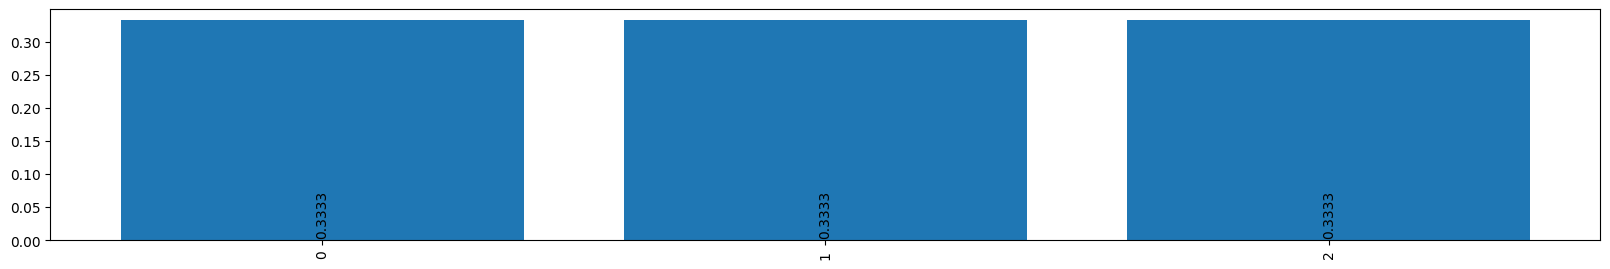

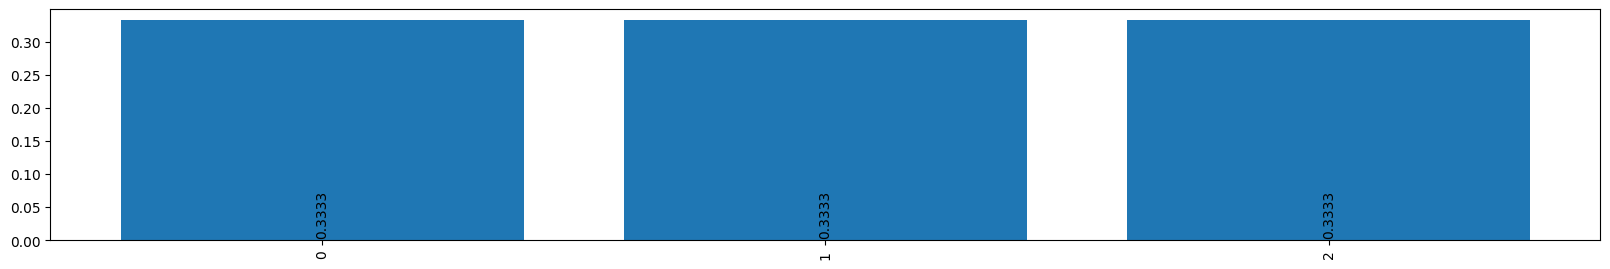

In [ ]:
def get_class_counts(df):
  unique, counts = np.unique(df, return_counts=True)
  return dict(zip(unique, counts))

def get_class_proportions(df):
  class_counts = get_class_counts(df)
  dictionary = {val[0]: round(val[1]/len(df), 4) for val in class_counts.items()}
  return dictionary

def plot_distribution(prop):
  int_dict = {int(k) : v for k, v in prop.items()}
  sorted_dict = dict(sorted(int_dict.items()))

  names = list(sorted_dict.keys())
  values = list(sorted_dict.values())

  plt.figure(figsize=(20, 3))
  plt.bar(range(len(sorted_dict)), values, tick_label=names)
  plt.xticks(range(len(sorted_dict)), names, rotation='vertical')

  ax = plt.gca()
  for bar, v in zip(ax.patches, values):
    plt.text(y=0.008, x=bar.get_x()+bar.get_width()/2, s=str(v), horizontalalignment="center", rotation='vertical')
  plt.show()


propTrain = get_class_proportions(lb.classes_[np.argmax(labels[list_train_IDs], axis=1)])
propVal = get_class_proportions(lb.classes_[np.argmax(labels[list_val_IDs], axis=1)])

plot_distribution(propTrain)
plot_distribution(propVal)

In [ ]:
y_integers = np.argmax(labels[list_train_IDs], axis=1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers)

train_class_weights = dict(enumerate(class_weights))


train_correct_class_weights=[None, train_class_weights]

In [ ]:
transform = A.Compose([
        A.ShiftScaleRotate(p=0.5),
        A.RandomBrightnessContrast(p=0.3)
    ],
    bbox_params=A.BboxParams(format='albumentations', min_visibility=0.1, label_fields=[]),
)

def augment(images, bboxes):
  augImages=[]
  augBBoxes=[]
  for i in range(len(images)):
    transformed = transform(image=cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB), bboxes=[bboxes[i]])
    augImages.append(cv2.cvtColor(transformed['image'], cv2.COLOR_RGB2BGR))
    augBBoxes.append(transformed['bboxes'][0])
  return (augImages, augBBoxes)

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, bboxes, labels, imagePaths, batch_size, dim,
                 n_classes, class_weights=None, augmentation=False, shuffle=False):

        'Initialization'
        self.shuffle = shuffle
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.imagePaths = imagePaths
        self.bboxes = bboxes
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.class_weights = class_weights
        self.augmentation = augmentation
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))



    def __getitem__(self, index):
        'Generate one batch of data'

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]


        list_IDs_temp = [self.list_IDs[k] for k in indexes]


        if self.class_weights is None:

          X, y_label, y_bounding_box = self.__data_generation(list_IDs_temp)

          return X, {"class_label": y_label, "bounding_box":y_bounding_box}

        else:

          X, y_label, y_bounding_box, sample_weight = self.__data_generation(list_IDs_temp)

          return X, {"class_label": y_label, "bounding_box":y_bounding_box}, sample_weight

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)


        X = []
        y_label=[]
        y_bounding_box=[]


        for i, ID in enumerate(list_IDs_temp):
        #for i in list_IDs_temp:

            image = load_img(self.imagePaths[ID], target_size=(self.dim))
            image = img_to_array(image)
            X.append(image)


            y_label.append(self.labels[ID])
            y_bounding_box.append(self.bboxes[ID])

        X = np.array(X, dtype = "float32") / 255
        y_label = np.array(y_label)
        y_bounding_box = np.array(y_bounding_box, dtype="float32")


        if self.augmentation:
          (X, y_bounding_box) = augment(X, y_bounding_box)
          X = np.asarray(X)
          y_bounding_box = np.asarray(y_bounding_box)




        if self.class_weights is None:
          return X, y_label, y_bounding_box

        else:
          z = compute_sample_weight(train_class_weights, np.argmax(labels[list_IDs_temp], axis=1))
          return X, y_label, y_bounding_box, z

In [ ]:
training_generator = DataGenerator(list_train_IDs, bboxes, labels, imagePaths, **params,
                                   augmentation=False,
                                   #class_weights=train_correct_class_weights,
                                   shuffle=False)

validation_generator = DataGenerator(list_val_IDs, bboxes, labels, imagePaths, **params, shuffle=True)

In [ ]:
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras import Sequential

cnnInput = Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(HEIGHT, WIDTH, 3)),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(2),
    Conv2D(128, 3, activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(2),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(N_CLASSES, activation='softmax')])

flatten = cnnInput.output
flatten = Flatten()(flatten)

In [ ]:

bboxHead = Dense(64, activation="relu")(flatten)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",
	name="bounding_box")(bboxHead)


softmaxHead = Dense(len(lb.classes_), activation="softmax",
	name="class_label")(flatten)

model = Model(
	inputs=cnnInput.input,
	outputs=(bboxHead, softmaxHead))

In [ ]:
import tensorflow_addons as tfa


losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}

lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}

metric = {
	"class_label": [tfa.metrics.F1Score(N_CLASSES, threshold=0.5), "accuracy"],
	"bounding_box": iou_metric
}

opt = Adam(learning_rate=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=metric,)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_4_input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 126, 126, 32  896         ['conv2d_4_input[0][0]']         
                                )                                                                 
                                                                                                  
 conv2d_5 (Conv2D)              (None, 124, 124, 64  18496       ['conv2d_4[0][0]']               
                                )                                                           

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_sample_weight


early_stopping = EarlyStopping(patience=2)

print("[INFO] training model...")
H = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=1,
    verbose=1,
    callbacks=early_stopping
    )

print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")

print("[INFO] saving label binarizer...")
f = open(LB_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] training model...
1200/1200 [==============================] - 1151s 957ms/step - loss: 0.7750 - bounding_box_loss: 0.0334 - class_label_loss: 0.7415 - bounding_box_iou_metric: 0.6688 - class_label_f1_score: 0.6610 - class_label_accuracy: 0.6804 - val_loss: 0.7642 - val_bounding_box_loss: 0.0279 - val_class_label_loss: 0.7362 - val_bounding_box_iou_metric: 0.7082 - val_class_label_f1_score: 0.5424 - val_class_label_accuracy: 0.6450
[INFO] saving object detector model...
[INFO] saving label binarizer...


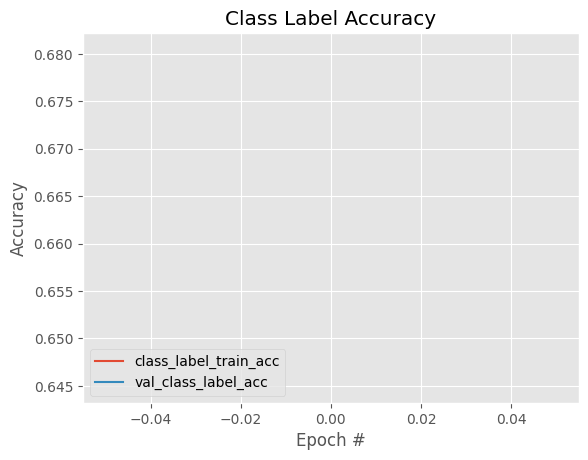

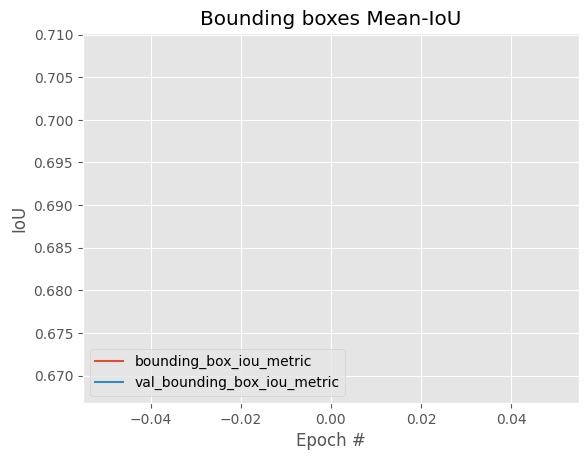

In [ ]:
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
EPOCHS_PASSED = len(H.history['loss'])
N = np.arange(0, EPOCHS_PASSED)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

for (i, l) in enumerate(lossNames):
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()

plt.tight_layout()
plotPath = os.path.sep.join([BASE_OUT, "losses.png"])
plt.savefig(plotPath)
plt.close()

plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

plotPath = os.path.sep.join([BASE_OUT, "accs.png"])
plt.savefig(plotPath)

plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["bounding_box_iou_metric"],
	label="bounding_box_iou_metric")
plt.plot(N, H.history["val_bounding_box_iou_metric"],
	label="val_bounding_box_iou_metric")
plt.title("Bounding boxes Mean-IoU")
plt.xlabel("Epoch #")
plt.ylabel("IoU")
plt.legend(loc="lower left")

plotPath = os.path.sep.join([BASE_OUT, "iou.png"])
plt.savefig(plotPath)

In [27]:
dependencies = {
    'iou_metric': iou_metric
}

def predict(imgPath):

  print("[INFO] loading object detector...")
  model = load_model(MODEL_PATH, custom_objects=dependencies)
  lb = pickle.loads(open(LB_PATH, "rb").read())


  image = load_img(imgPath, target_size=(HEIGHT, WIDTH))
  image = img_to_array(image) / 255.0
  image = np.expand_dims(image, axis=0)


  (boxPreds, labelPreds) = model.predict(image)
  (startX, startY, endX, endY) = boxPreds[0]



  i = np.argmax(labelPreds, axis=-1)
  label = lb.classes_[i][0]
  label = classes.get(int(label))



  image = cv2.imread(imgPath)
  image = imutils.resize(image, width=200)
  (h, w) = image.shape[:2]


  startX = int(startX * w)
  startY = int(startY * h)
  endX = int(endX * w)
  endY = int(endY * h)


  y = startY - 10 if startY - 10 > 10 else startY + 10
  cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,
    0.65, (0, 255, 0), 2)
  cv2.rectangle(image, (startX, startY), (endX, endY),
    (0, 255, 0), 2)


  cv2_imshow(image)
  cv2.waitKey(0)

In [41]:
print("[INFO] Evaluating the model on validation data...")
validation_results = model.evaluate(validation_generator)


print(f"Validation Loss: {validation_results[0]}")
print(f"Validation Accuracy: {validation_results[1]}")

[INFO] Evaluating the model on validation data...
300/300 [==============================] - 117s 391ms/step - loss: 0.7642 - bounding_box_loss: 0.0279 - class_label_loss: 0.7362 - bounding_box_iou_metric: 0.7082 - class_label_f1_score: 0.5424 - class_label_accuracy: 0.6450
Validation Loss: 0.7641822099685669
Validation Accuracy: 0.027934547513723373
